In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


## Submodular Selection
Author: Jacob Schreiber <jmschreiber91@gmail.com>

There is a growing amount of data in the world. Much of this data is used to train machine learning models that do things like generate text, classify objects in images, and enable precision medicine. However, as the sizes of the data sets used to train these models increases, so to does the computational cost. While some of this cost can be mitigated through parallelized implementations and the utilization of GPUs, this requires the hardware or money that individuals or small organizations don't always have.

Submodular selection tackles the problem of selecting a representative subset from a large nuber of objects. More recently it has been used to summarize massive data sets into smaller ones that remain useful for training machine learning models through the elimination of redundancy or noise. Briely, the way that submodular search works is that one defines a function that returns approximately how useful a set of samples are, and then greedily optimizes that function. This approximation of how useful a sample is typically quick to calculate, in contrast with the exact solution, which would involve retraining a machine learning model with the inclusion of each sample at each iteration.

apricot implements two forms of submodular selection: feature based functions and facility location. These functions will be described in more detail below, but feature based functions force a diversity of feature values by modeling the saturation of each feature in the growing subset, whereas facility location functions force diversity in the original space by measuring the distance from all points to their nearest representative.

### Feature Based Submodularity

A problem with some submodular functions is that they do not scale well across massive data sets. For example, the facility location function first involves calculating some pairwise information across the data set, and second involves recalculating this pairwise measurement each time a sample is potentially added to the growing set. While optimizations exist that can greatly speed this up when compared to a naive implementation, it still can be prohibitively slow in some cases.

A different type of submodular function, called a "feature based" function, does not involve calculating pairwise information and is much more scalable to large data sets. These functions involve calculating how "saturated" a particular feature is and preferentially selecting samples that have large feature values that have not yet been seen. These function takes the following form:

\begin{equation}
f(X) = \sum\limits_{u \in U} w_{u} \phi_{u} \left( \sum\limits_{x \in X} m_{u}(x) \right)
\end{equation}

In this equation, $U$ refers to all features, or dimensions, of a sample, and $u$ refers to a specific feature. $X$ refers to the original data set that we are selecting from and $x$ refers to a single sample from that data set. $w$ is a vector of weights that indicate how important each feature is, with $w_{u}$ being a scalar referring to how important feature $u$ is. Frequently these weights are uniform. $\phi$ refers to a set of saturating functions, such as $sqrt(X)$ or $log(X + 1)$ that take some 


Feature based functions perform best when the value of each feature corresponds roughly to some notion of how important it is rather than being an arbitrary value. For example, when considering audio data, a spike in noise indicates that something is happening in an otherwise silent background, and when considering financial portfolios the more money a person has in a stock or fund, the more important that fund is for them. Examples of features where feature based functions are not likely to work well on are those without this notion, including categorical variables such as car color or bimodally distributed variables.

The reason that feature based funtions don't perform well when thre is no notion of importance can easily be visualized by looking at two Gaussian blobs. One might expect that a good summarization function would select a similar number of points from each blob, perhaps near the boundary between the two. Let's see what a feature based function does.

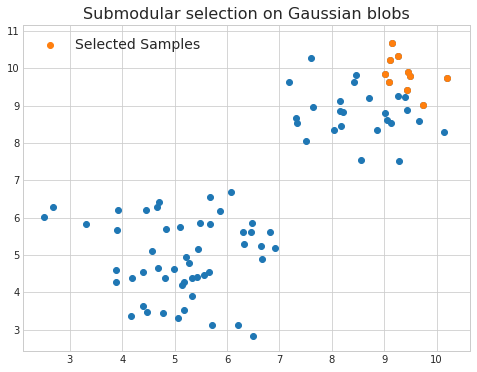

In [2]:
from apricot import FeatureBasedSelection

X = numpy.concatenate([numpy.random.normal(5, 1, size=(50, 2)), numpy.random.normal(9, 1, size=(35, 2))])
Xi = FeatureBasedSelection(10).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.title("Submodular selection on Gaussian blobs", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Xi[:,0], Xi[:,1], label="Selected Samples")
plt.legend(fontsize=14)
plt.show()

The feature based selection chooses those samples with the highest absolute magnitude. This is not surprising because the function is trying to maximize the sum of the saturated values over each feature. You can maximize this value by always selecting the biggest values.

A reasonable point may be that there is a strong positive correlation between the two variables and so of course those samples with a high value in one dimension will have a high value in the other dimension. By rotating the points to be negatvely correlated we can see that we're still selecting points based on their distance to the top right of the plot.

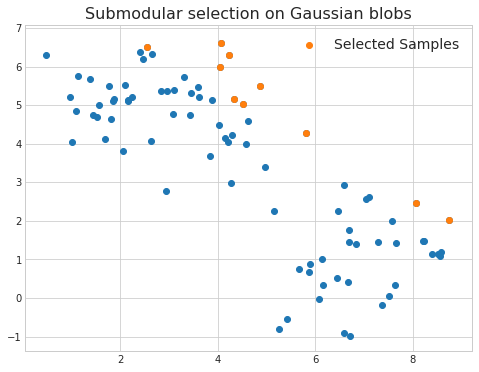

In [3]:
X = numpy.concatenate([numpy.random.normal((3, 5), 1, size=(50, 2)), numpy.random.normal((7, 1), 1, size=(35, 2))])
Xi = FeatureBasedSelection(10).fit_transform(X)

plt.figure(figsize=(8, 6))
plt.title("Submodular selection on Gaussian blobs", fontsize=16)
plt.scatter(X[:,0], X[:,1])
plt.scatter(Xi[:,0], Xi[:,1], label="Selected Samples")
plt.legend(fontsize=14)
plt.show()

In [4]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

cats = ('sci.med', 'sci.space')
stop = ('headers', 'footers', 'quotes')

train_data = fetch_20newsgroups(subset='train', categories=cats, remove=stop)
test_data = fetch_20newsgroups(subset='test', categories=cats, remove=stop)

X_train, y_train = train_data.data, train_data.target
X_test, y_test = test_data.data, test_data.target

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

X_train = vectorizer.fit_transform(X_train).todense()
X_test = vectorizer.transform(X_test).todense()

X_train.shape, X_test.shape

((1187, 1000), (790, 1000))

In [5]:
from sklearn.linear_model import LogisticRegressionCV

In [6]:
'''
submodular_accuracy, random_accuracy = [], []

selection = FeatureBasedSelection(1000)
selection.fit_transform(X_train)

random_idxs = []
for i in range(20):
    idxs = numpy.arange(X_train.shape[0])
    numpy.random.shuffle(idxs)
    random_idxs.append(idxs)

x = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    
for n in tqdm(x):
    X_train_small = X_train[selection.indices[:n]]
    y_train_small = y_train[selection.indices[:n]]

    model = LogisticRegressionCV()
    model.fit(X_train_small, y_train_small)
    submodular_acc = model.score(X_test, y_test)
    submodular_accuracy.append(submodular_acc)

    accs = []
    for i in range(20):
        X_train_small = X_train[random_idxs[i][:n]]
        y_train_small = y_train[random_idxs[i][:n]]

        model = LogisticRegressionCV()
        model.fit(X_train_small, y_train_small)
        acc = model.score(X_test, y_test)
        accs.append(acc)
        
    random_accuracy.append(accs)
'''

'\nsubmodular_accuracy, random_accuracy = [], []\n\nselection = FeatureBasedSelection(1000)\nselection.fit_transform(X_train)\n\nrandom_idxs = []\nfor i in range(20):\n    idxs = numpy.arange(X_train.shape[0])\n    numpy.random.shuffle(idxs)\n    random_idxs.append(idxs)\n\nx = [20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]\n    \nfor n in tqdm(x):\n    X_train_small = X_train[selection.indices[:n]]\n    y_train_small = y_train[selection.indices[:n]]\n\n    model = LogisticRegressionCV()\n    model.fit(X_train_small, y_train_small)\n    submodular_acc = model.score(X_test, y_test)\n    submodular_accuracy.append(submodular_acc)\n\n    accs = []\n    for i in range(20):\n        X_train_small = X_train[random_idxs[i][:n]]\n        y_train_small = y_train[random_idxs[i][:n]]\n\n        model = LogisticRegressionCV()\n        model.fit(X_train_small, y_train_small)\n        acc = model.score(X_test, y_test)\n        accs.append(acc)\n        \n    rand

In [7]:
'''
random_accuracy = numpy.array(random_accuracy)

#x = [20, 50, 100, 200, 500, 1000]

plt.title("Submodular selection versus random selection")
plt.scatter(x, submodular_accuracy)
plt.plot(x, submodular_accuracy, label="Submodular Selection")


plt.plot(x, random_accuracy.mean(axis=1), color='m')
#plt.plot(x, random_accuracy.min(axis=1), alpha=0.3, color='m')
#plt.plot(x, random_accuracy.max(axis=1), alpha=0.3, color='m')

plt.scatter(x, random_accuracy.mean(axis=1), color='m')
#plt.scatter(x, random_accuracy.min(axis=1), s=10, color='m')
#plt.scatter(x, random_accuracy.max(axis=1), s=10, color='m')
plt.fill_between(x, random_accuracy.min(axis=1), random_accuracy.max(axis=1), color='m', alpha=0.2)
'''

'\nrandom_accuracy = numpy.array(random_accuracy)\n\n#x = [20, 50, 100, 200, 500, 1000]\n\nplt.title("Submodular selection versus random selection")\nplt.scatter(x, submodular_accuracy)\nplt.plot(x, submodular_accuracy, label="Submodular Selection")\n\n\nplt.plot(x, random_accuracy.mean(axis=1), color=\'m\')\n#plt.plot(x, random_accuracy.min(axis=1), alpha=0.3, color=\'m\')\n#plt.plot(x, random_accuracy.max(axis=1), alpha=0.3, color=\'m\')\n\nplt.scatter(x, random_accuracy.mean(axis=1), color=\'m\')\n#plt.scatter(x, random_accuracy.min(axis=1), s=10, color=\'m\')\n#plt.scatter(x, random_accuracy.max(axis=1), s=10, color=\'m\')\nplt.fill_between(x, random_accuracy.min(axis=1), random_accuracy.max(axis=1), color=\'m\', alpha=0.2)\n'

### Facility Location

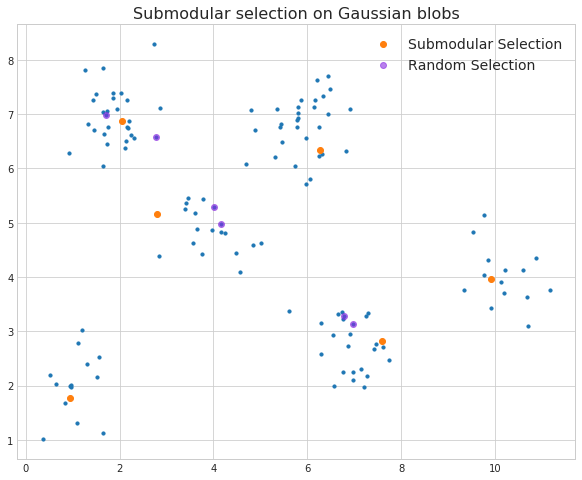

In [8]:
from apricot import FacilityLocationSelection

X = numpy.concatenate([numpy.random.normal((1, 2), 0.5, size=(15, 2)),
                       numpy.random.normal((7, 3), 0.5, size=(25, 2)),
                       numpy.random.normal((6, 7), 0.5, size=(30, 2)),
                       numpy.random.normal((2, 7), 0.5, size=(30, 2)),
                       numpy.random.normal((10, 4), 0.5, size=(15, 2)),
                       numpy.random.normal((4, 5), 0.5, size=(20, 2))])

Xi = FacilityLocationSelection(6, 'euclidean').fit_transform(X)
Xr = numpy.random.choice(numpy.arange(X.shape[0]), size=6)
Xr = X[Xr]

plt.figure(figsize=(10, 8))
plt.title("Submodular selection on Gaussian blobs", fontsize=16)
plt.scatter(X[:,0], X[:,1], s=10)
plt.scatter(Xi[:,0], Xi[:,1], label="Submodular Selection")
plt.scatter(Xr[:,0], Xr[:,1], color="#8A2BE2", label="Random Selection", alpha=0.6)
plt.legend(fontsize=14)
plt.show()

In [9]:
Xr

array([[2.76726149, 6.57425946],
       [6.97555385, 3.13782694],
       [4.16523367, 4.98154953],
       [6.78922559, 3.28115873],
       [1.69914118, 6.97788368],
       [4.00679132, 5.29798393]])

In [10]:
from sklearn.datasets import load_digits

data = load_digits()
X, y = data.data, data.target 

idx = numpy.arange(X.shape[0])
numpy.random.shuffle(idx)

X, y = X[idx], y[idx]
X_train, y_train = X[:1250], y[:1250]
X_test, y_test = X[1250:], y[1250:]

In [11]:
X.shape

(1797, 64)

In [12]:
selector = FacilityLocationSelection(X_train.shape[0], 'euclidean', verbose=True)
selector.fit_transform(X_train)

selector2 = FeatureBasedSelection(X_train.shape[0], 'sqrt', verbose=True)
selector2.fit_transform(X_train)

100%|██████████| 1250/1250 [00:00<00:00, 2774.18it/s]


array([[ 0.,  0.,  4., ..., 12.,  1.,  0.],
       [ 0.,  0.,  8., ...,  7.,  0.,  0.],
       [ 0.,  0.,  6., ..., 10.,  1.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [13]:
indices = numpy.arange(X_train.shape[0])
numpy.random.shuffle(indices)

submodular_acc, random_acc = [], []
n_samples = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1250]

for n in n_samples:
    Xi, yi = X_train[selector.indices[:n]], y_train[selector.indices[:n]]
    
    model = LogisticRegressionCV().fit(Xi, yi)
    submodular_acc.append(model.score(X_test, y_test))
    print submodular_acc[-1],
 
    Xi, yi = X_train[selector2.indices[:n]], y_train[selector2.indices[:n]]
    
    model = LogisticRegressionCV().fit(Xi, yi)
    #submodular_acc.append(model.score(X_test, y_test))
    print model.score(X_test, y_test),

    Xi, yi = X_train[indices[:n]], y_train[indices[:n]]
    
    model = LogisticRegressionCV().fit(Xi, yi)
    random_acc.append(model.score(X_test, y_test))
    print random_acc[-1]

0.9250457038391224 0.8464351005484461 0.903107861060329
0.943327239488117 0.8884826325411335 0.9250457038391224
0.943327239488117 0.9378427787934186 0.946983546617916
0.946983546617916 0.9414990859232175 0.9414990859232175
0.9542961608775137 0.9524680073126143 0.946983546617916
0.9488117001828154 0.9378427787934186 0.9524680073126143
0.946983546617916 0.9323583180987203 0.946983546617916
0.946983546617916 0.9451553930530164 0.9597806215722121
0.9506398537477148 0.9506398537477148 0.9542961608775137
0.9579524680073126 0.9488117001828154 0.9506398537477148
0.9670932358318098 0.9488117001828154 0.9652650822669104
0.9561243144424132 0.9579524680073126 0.9597806215722121
0.9488117001828154 0.9561243144424132 0.9561243144424132


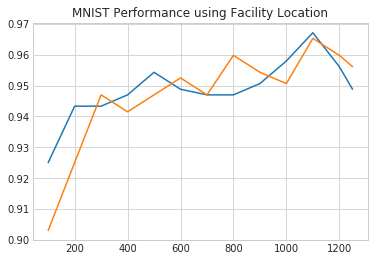

In [14]:
plt.title("MNIST Performance using Facility Location")
plt.plot(n_samples, submodular_acc)
plt.plot(n_samples, random_acc)

In [15]:
model = LogisticRegressionCV().fit(X_train, y_train)
print model.score(X_test, y_test)

0.9542961608775137


In [16]:
### Regression Problems

In [75]:
from sklearn.datasets import fetch_covtype
from sklearn.preprocessing import MinMaxScaler

data = fetch_covtype()
X, y = data.data, data.target
X = X[(y == 1) | (y == 2)]
y = y[(y == 1) | (y == 2)] - 1

idx = numpy.arange(X.shape[0])
numpy.random.shuffle(idx)

X_train, y_train = X[:20000], y[:20000]
X_test, y_test = X[20000:], y[20000:]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
selector2 = FeatureBasedSelection(X_train.shape[0], 'log', verbose=True)
selector2.fit_transform(X_train)




  0%|          | 0/20000 [00:00<?, ?it/s]


  0%|          | 3/20000 [00:00<30:29, 10.93it/s]


  0%|          | 4/20000 [00:00<39:24,  8.46it/s]


  0%|          | 5/20000 [00:00<51:34,  6.46it/s]


  0%|          | 6/20000 [00:00<51:48,  6.43it/s]


  0%|          | 7/20000 [00:01<54:50,  6.08it/s]


  0%|          | 9/20000 [00:01<44:07,  7.55it/s]


  0%|          | 10/20000 [00:01<43:52,  7.59it/s]


  0%|          | 12/20000 [00:01<38:54,  8.56it/s]


  0%|          | 13/20000 [00:01<42:39,  7.81it/s]


  0%|          | 15/20000 [00:01<40:42,  8.18it/s]


  0%|          | 16/20000 [00:02<57:12,  5.82it/s]


  0%|          | 17/20000 [00:02<50:48,  6.55it/s]


  0%|          | 19/20000 [00:02<43:54,  7.58it/s]


  0%|          | 22/20000 [00:02<35:33,  9.36it/s]


  0%|          | 25/20000 [00:02<29:08, 11.43it/s]


  0%|          | 27/20000 [00:02<27:19, 12.18it/s]


  0%|          | 30/20000 [00:02<23:29, 14.17it/s]


  0%|          | 32/20000 [00:03<22:20, 14.90it/s]


  0%|

  4%|▍         | 864/20000 [00:18<03:21, 95.00it/s]


  4%|▍         | 875/20000 [00:18<03:17, 96.92it/s]


  4%|▍         | 885/20000 [00:18<03:19, 95.62it/s]


  4%|▍         | 895/20000 [00:18<03:24, 93.39it/s]


  5%|▍         | 907/20000 [00:19<03:11, 99.89it/s]


  5%|▍         | 920/20000 [00:19<02:57, 107.35it/s]


  5%|▍         | 932/20000 [00:19<03:02, 104.45it/s]


  5%|▍         | 946/20000 [00:19<02:50, 111.44it/s]


  5%|▍         | 960/20000 [00:19<02:41, 117.83it/s]


  5%|▍         | 973/20000 [00:19<02:45, 115.19it/s]


  5%|▍         | 985/20000 [00:19<02:43, 116.48it/s]


  5%|▍         | 997/20000 [00:19<02:46, 114.40it/s]


  5%|▌         | 1011/20000 [00:19<02:37, 120.47it/s]


  5%|▌         | 1024/20000 [00:20<02:36, 121.48it/s]


  5%|▌         | 1037/20000 [00:20<02:42, 116.91it/s]


  5%|▌         | 1054/20000 [00:20<02:28, 127.65it/s]


  5%|▌         | 1068/20000 [00:20<02:28, 127.48it/s]


  5%|▌         | 1082/20000 [00:20<02:35, 121.93it/s]


  5%|▌   

 12%|█▏        | 2484/20000 [00:34<02:08, 136.84it/s]


 13%|█▎        | 2505/20000 [00:34<01:54, 152.41it/s]


 13%|█▎        | 2526/20000 [00:34<01:45, 165.52it/s]


 13%|█▎        | 2544/20000 [00:34<01:44, 167.21it/s]


 13%|█▎        | 2562/20000 [00:34<01:50, 158.38it/s]


 13%|█▎        | 2579/20000 [00:34<01:50, 157.42it/s]


 13%|█▎        | 2596/20000 [00:35<01:48, 159.81it/s]


 13%|█▎        | 2616/20000 [00:35<01:42, 169.80it/s]


 13%|█▎        | 2637/20000 [00:35<01:36, 180.06it/s]


 13%|█▎        | 2656/20000 [00:35<01:51, 155.72it/s]


 13%|█▎        | 2673/20000 [00:35<01:59, 144.52it/s]


 13%|█▎        | 2690/20000 [00:35<01:55, 150.11it/s]


 14%|█▎        | 2709/20000 [00:35<01:48, 159.05it/s]


 14%|█▎        | 2726/20000 [00:35<01:47, 160.20it/s]


 14%|█▎        | 2747/20000 [00:35<01:41, 170.16it/s]


 14%|█▍        | 2770/20000 [00:36<01:33, 183.88it/s]


 14%|█▍        | 2790/20000 [00:36<01:35, 181.14it/s]


 14%|█▍        | 2809/20000 [00:36<01:37, 176.27

 25%|██▌       | 5093/20000 [00:50<02:37, 94.62it/s]


 26%|██▌       | 5109/20000 [00:50<02:18, 107.50it/s]


 26%|██▌       | 5122/20000 [00:50<02:17, 108.41it/s]


 26%|██▌       | 5134/20000 [00:51<02:37, 94.68it/s] 


 26%|██▌       | 5157/20000 [00:51<02:09, 114.79it/s]


 26%|██▌       | 5193/20000 [00:51<01:43, 143.49it/s]


 26%|██▌       | 5231/20000 [00:51<01:23, 176.27it/s]


 26%|██▋       | 5276/20000 [00:51<01:08, 215.21it/s]


 27%|██▋       | 5313/20000 [00:51<01:00, 244.56it/s]


 27%|██▋       | 5354/20000 [00:51<00:52, 277.68it/s]


 27%|██▋       | 5390/20000 [00:51<00:49, 297.75it/s]


 27%|██▋       | 5429/20000 [00:51<00:45, 317.45it/s]


 27%|██▋       | 5474/20000 [00:52<00:41, 347.94it/s]


 28%|██▊       | 5513/20000 [00:52<00:41, 350.03it/s]


 28%|██▊       | 5551/20000 [00:52<00:41, 352.04it/s]


 28%|██▊       | 5589/20000 [00:52<00:43, 330.16it/s]


 28%|██▊       | 5624/20000 [00:52<00:48, 294.72it/s]


 28%|██▊       | 5656/20000 [00:52<00:50, 283.09i

 55%|█████▍    | 10918/20000 [01:05<00:21, 419.93it/s]


 55%|█████▍    | 10972/20000 [01:05<00:25, 349.97it/s]


 55%|█████▌    | 11018/20000 [01:05<00:30, 295.90it/s]


 55%|█████▌    | 11057/20000 [01:05<00:32, 271.33it/s]


 55%|█████▌    | 11091/20000 [01:06<00:32, 275.55it/s]


 56%|█████▌    | 11124/20000 [01:06<00:35, 251.73it/s]


 56%|█████▌    | 11153/20000 [01:06<00:35, 248.57it/s]


 56%|█████▌    | 11181/20000 [01:06<00:35, 251.34it/s]


 56%|█████▌    | 11208/20000 [01:06<00:35, 244.77it/s]


 56%|█████▌    | 11234/20000 [01:06<00:37, 236.09it/s]


 56%|█████▋    | 11264/20000 [01:06<00:35, 249.18it/s]


 56%|█████▋    | 11290/20000 [01:06<00:37, 233.34it/s]


 57%|█████▋    | 11317/20000 [01:06<00:35, 242.35it/s]


 57%|█████▋    | 11352/20000 [01:07<00:32, 265.35it/s]


 57%|█████▋    | 11399/20000 [01:07<00:28, 304.77it/s]


 57%|█████▋    | 11452/20000 [01:07<00:24, 349.09it/s]


 57%|█████▋    | 11492/20000 [01:07<00:30, 282.64it/s]


 58%|█████▊    | 11526/20000 [0

array([[0.82337317, 0.82777778, 0.3442623 , ..., 0.        , 0.        ,
        0.        ],
       [0.54581673, 0.79166667, 0.18032787, ..., 0.        , 0.        ,
        0.        ],
       [0.82602922, 0.84166667, 0.27868852, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.25298805, 0.04444444, 0.04918033, ..., 0.        , 0.        ,
        0.        ],
       [0.45949535, 0.        , 0.06557377, ..., 0.        , 0.        ,
        0.        ],
       [0.2815405 , 0.01944444, 0.13114754, ..., 0.        , 0.        ,
        0.        ]])

In [77]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

indices = numpy.arange(X_train.shape[0])
numpy.random.shuffle(indices)

submodular_acc, random_acc = [], []
n_samples = [100, 200, 500, 1000, 2000, 5000, 10000, 20000]

print numpy.unique(y_train, return_counts=True)

for n in n_samples:
    Xi, yi = X_train[selector2.indices[:n]], y_train[selector2.indices[:n]]
    #print numpy.unique(yi, return_counts=True)
    
    model = LogisticRegressionCV().fit(Xi, yi)
    submodular_acc.append(model.score(X_test, y_test))
    print submodular_acc[-1],

    Xi, yi = X_train[indices[:n]], y_train[indices[:n]]
    
    model = LogisticRegressionCV().fit(Xi, yi)
    random_acc.append(model.score(X_test, y_test))
    print random_acc[-1]

(array([0, 1], dtype=int32), array([ 4968, 15032]))
0.6189194365462042 0.5646092423091251
0.6700242664808973 0.6135989106391576
0.7042435824313203 0.7176353966506784
0.7136660486045195 0.7322289594036296
0.7201041375086553 0.7457870400575829
0.751282250952875 0.7428910576018487
0.7321300413982376 0.7466499418067479
0.5646092423091251 0.7455786808547358


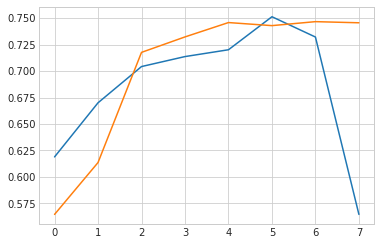

In [78]:
plt.plot(submodular_acc)
plt.plot(random_acc)

In [ ]:
help(RidgeCV.score)

In [ ]:
import sklearn
help(sklearn.datasets)